# **라이브러리 불러오기**

In [ ]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 로드**

In [ ]:
df_2024 = pd.read_csv("/content/drive/MyDrive/tour/cluster1.csv", index_col=0)

/tmp/ipython-input-4-3314172470.py:1: DtypeWarning: Columns (24,25,27,28,29,30,50,60,61,65,66,68,76,81,117,118,119,125,126,127,134,227,228,229,233,236,240,241,247,277,283) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2024 = pd.read_csv("/content/drive/MyDrive/tour/cluster1.csv", index_col=0)


In [ ]:
df_cluster1_2024 = df_2024.copy()
df_cluster1_2024.head()

,pnid,MVIT,RVIT,XRVIT,TYP,Q1,Q1_1a1,Q1_1a2,Q1_1a3,Q2a1,...,D_NUM,D_GUB,weight1,weight2,weight3,weight4,weight,cluster,재방문자,재방문의향긍정
9,69,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문","한국에서 행사(가족행사, 스포츠 행사 등)가 있어서",NaN,NaN,NaN,...,1 회,개 별 여 행,1005.032741,NaN,NaN,NaN,1005.032741,1,False,False
19,85,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행",사업 또는 전문 활동,NaN,NaN,NaN,NaN,...,1 회,개 별 여 행,1210.286770,NaN,NaN,NaN,1210.286770,1,False,False
28,101,3,3회,재방문,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문",과거 방문 경험이 좋아서,"한류 콘텐츠(K-pop, 드라마, 영화 등)를 접하고 나서",계획한 여행 경비에 적합한 여행지여서,태국,...,3 회,개 별 여 행,554.457606,NaN,NaN,NaN,554.457606,1,True,False
31,104,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","교육(어학 프로그램, 연수 등)",NaN,NaN,NaN,NaN,...,1 회,개 별 여 행,99.583958,NaN,NaN,NaN,99.583958,1,False,False
33,107,1,1회,NaN,"개별여행 : 일정, 숙박 등 여행의 모든 준비를 직접 수행","친구, 친지 방문",새로운 국가에 가고 싶어서,계획한 여행 경비에 적합한 여행지여서,NaN,일본,...,1 회,개 별 여 행,550.525754,NaN,NaN,NaN,550.525754,1,False,False


In [ ]:
df_cluster1_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4158 entries, 9 to 16215
Columns: 405 entries, pnid to 재방문의향긍정
dtypes: bool(2), float64(138), int64(20), object(245)
memory usage: 12.8+ MB


# **지역별 재방문 의향 분포**

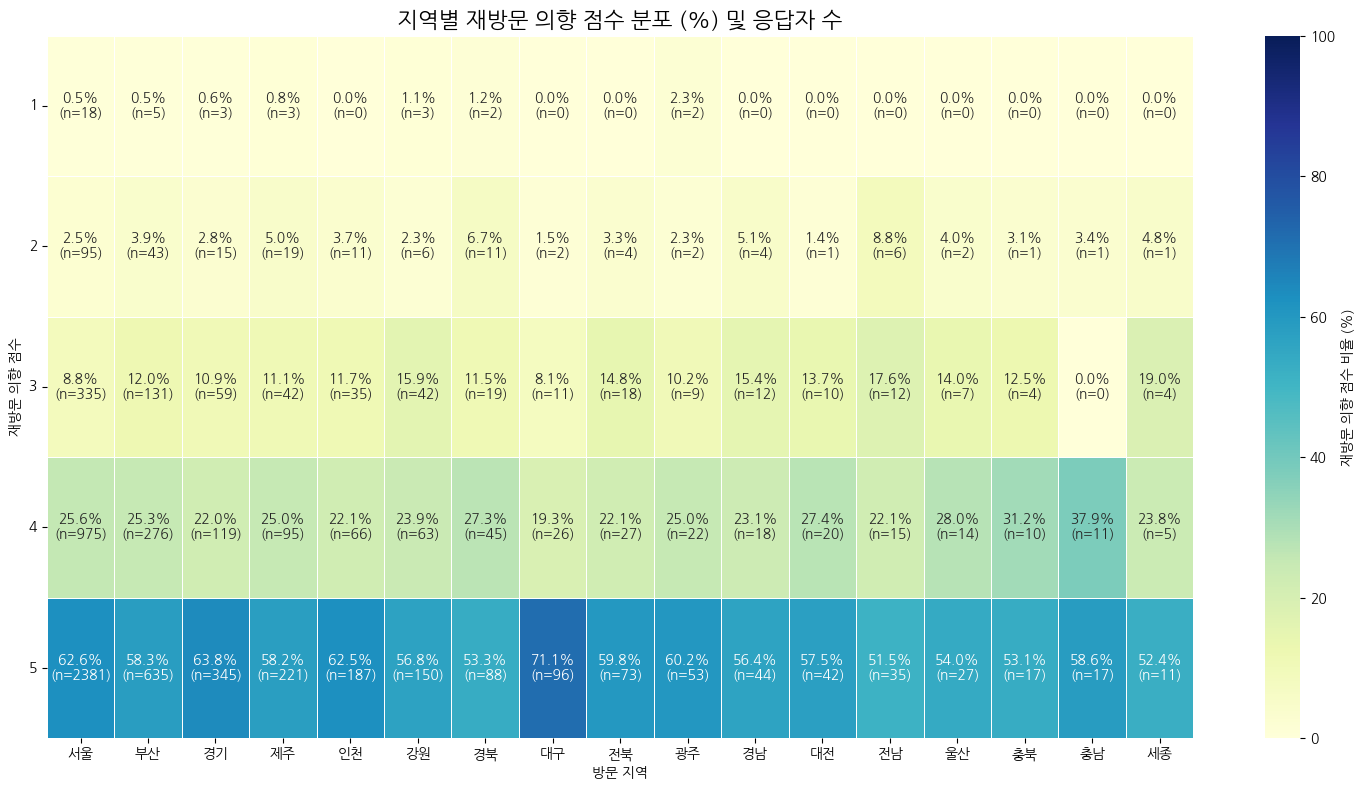

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 적용

# 1. Q13 점수 매핑
q13_map = {
    '① 전혀 그렇지 않다': 1,
    '② 별로 그렇지 않다': 2,
    '③ 보통': 3,
    '④ 대체로 그렇다': 4,
    '⑤ 매우 그렇다': 5
}
df_cluster1_2024["Q13_numeric"] = df_cluster1_2024["Q13"].map(q13_map)

# 2. 지역 관련 컬럼 추출
region_cols = [col for col in df_cluster1_2024.columns if col.endswith("일TOT")]

# 3. 지역별 방문자 수 계산
region_visits = {
    col.replace("일TOT", ""): (df_cluster1_2024[col] > 0).sum()
    for col in region_cols
}
sorted_regions = sorted(region_visits, key=region_visits.get, reverse=True)

# 4. 비율과 카운트 히트맵용 데이터프레임 생성
percentage_df = pd.DataFrame(index=range(1, 6))
count_df = pd.DataFrame(index=range(1, 6))

for col in region_cols:
    region = col.replace("일TOT", "")
    visited = df_cluster1_2024[df_cluster1_2024[col] > 0]
    value_counts = visited["Q13_numeric"].value_counts()
    value_percents = visited["Q13_numeric"].value_counts(normalize=True) * 100

    counts_full = pd.Series({i: 0 for i in range(1, 6)})
    percents_full = pd.Series({i: 0.0 for i in range(1, 6)})

    counts_full.update(value_counts)
    percents_full.update(value_percents)

    percentage_df[region] = percents_full
    count_df[region] = counts_full

# 5. 열 순서 정렬
percentage_df = percentage_df[sorted_regions]
count_df = count_df[sorted_regions]

# 6. 주석 텍스트 생성: "42.3%\n(n=101)" 형태
annot_df = percentage_df.copy()
for col in annot_df.columns:
    annot_df[col] = [
        f"{percentage_df[col][i]:.1f}%\n(n={int(count_df[col][i])})"
        for i in percentage_df.index
    ]

# 7. 시각화
plt.figure(figsize=(15, 8))
sns.heatmap(
    percentage_df,
    annot=annot_df,
    fmt="",
    cmap="YlGnBu",
    linewidths=0.4,
    cbar_kws={"label": "재방문 의향 점수 비율 (%)"},
    vmin=0, vmax=100
)

plt.title("지역별 재방문 의향 점수 분포 (%) 및 응답자 수", fontsize=16)
plt.xlabel("방문 지역")
plt.ylabel("재방문 의향 점수")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **대구**
1. 71.1% 라는 **충성도**를 보여준 것이 인상깊어 대구를 분석한 후, 다른 지역에 전파, 연동의 느낌을 주고싶었음.
2. 문제는 표본수가 너무 적음.

In [ ]:
# 1. 대구 방문자만 필터링 (Q9_2a11은 방문지역 변수)
dg_visitors = df_cluster1_2024[df_cluster1_2024['Q9_2a11'] == '대구']

# 2. Q13 응답값 결측 제거
dg_q13 = dg_visitors[dg_visitors['Q13_numeric'].notna()]

# 3. 재방문의향 5점 수 및 전체 수
dg_q13_5_count = (dg_q13['Q13_numeric'] == 5).sum()
dg_q13_total = dg_q13.shape[0]
dg_q13_5_ratio = dg_q13_5_count / dg_q13_total * 100

# 4. 결과 출력
print(f"✅ 대구 방문자 중 재방문의향 5점 비율: {dg_q13_5_ratio:.1f}% ({dg_q13_5_count} / {dg_q13_total})")


✅ 대구 방문자 중 재방문의향 5점 비율: 71.1% (96 / 135)


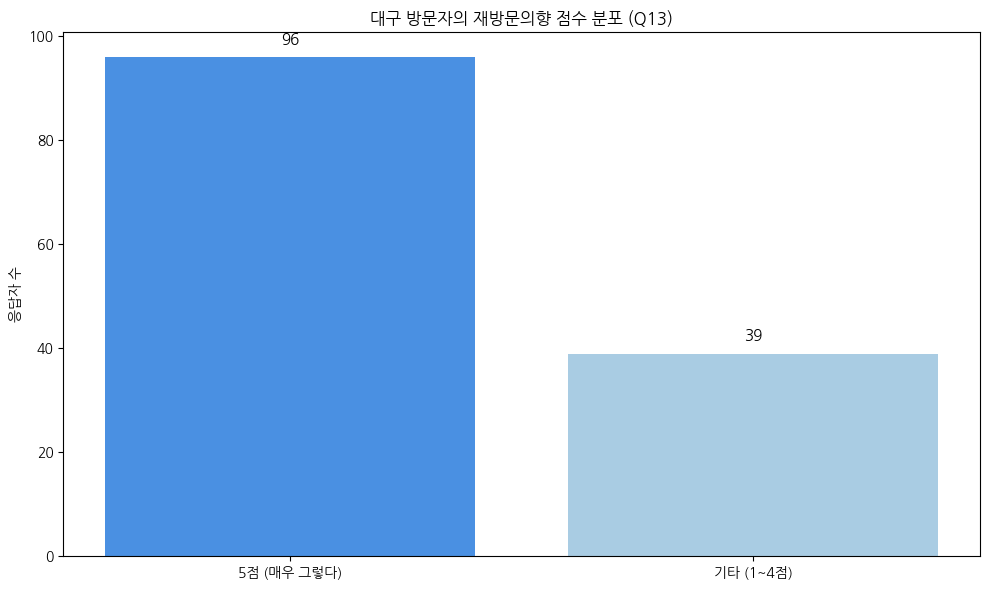

In [ ]:
import matplotlib.pyplot as plt

labels = ['5점 (매우 그렇다)', '기타 (1~4점)']
values = [dg_q13_5_count, dg_q13_total - dg_q13_5_count]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#4A90E2', '#A9CCE3'])

# 막대 위에 수치 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f"{int(height)}",
             ha='center', va='bottom', fontsize=11)

plt.title("대구 방문자의 재방문의향 점수 분포 (Q13)")
plt.ylabel("응답자 수")
plt.tight_layout()
plt.show()



## **대구 방문자의 참여 활동 (누적)**

In [ ]:
# 1. 대구 방문자 필터링 (Q9_2a11이 '대구')
df_daegu = df_cluster1_2024[df_cluster1_2024["Q9_2a11"] == "대구"]

# 2. 활동 컬럼 정의 (Q8a01~Q8a20)
activity_cols = [f"Q8a{str(i).zfill(2)}" for i in range(1, 21)]

# 3. 각 활동별 참여자 수 계산 (NaN 무시됨 → 값이 존재하는 개수만 집계됨)
activity_participation = df_daegu[activity_cols].notna().sum().sort_values(ascending=False)

q8_activity_map = {
    "Q8a01": "식도락 관광",
    "Q8a02": "쇼핑",
    "Q8a03": "자연경관 감상",
    "Q8a04": "휴양/휴식",
    "Q8a05": "고궁/역사 유적지 방문",
    "Q8a06": "전통문화체험",
    "Q8a07": "박물관/전시관 관람",
    "Q8a08": "K-POP/드라마 촬영지 방문",
    "Q8a09": "공연 관람",
    "Q8a10": "지역 축제 참여",
    "Q8a11": "유흥/카지노",
    "Q8a12": "오락(놀이공원/테마파크)",
    "Q8a13": "뷰티/미용 관광",
    "Q8a14": "건강검진/의료 관광",
    "Q8a15": "스포츠 관람",
    "Q8a16": "스포츠 참가",
    "Q8a17": "연수/교육",
    "Q8a18": "비즈니스 전문활동",
    "Q8a19": "연구/학술활동",
    "Q8a20": "기타"
}

# 활동 참여 시리즈: Q8 코드 → 참여자 수
activity_named = activity_participation.rename(index=q8_activity_map)

# 정렬된 상태 그대로 출력
print(activity_named)

쇼핑                  99
식도락 관광              96
자연경관 감상             93
고궁/역사 유적지 방문        92
박물관/전시관 관람          64
전통문화체험              50
휴양/휴식               31
비즈니스 전문활동           28
오락(놀이공원/테마파크)       25
지역 축제 참여            21
유흥/카지노              20
K-POP/드라마 촬영지 방문    11
뷰티/미용 관광            11
공연 관람               10
연수/교육                9
연구/학술활동              9
스포츠 관람               7
스포츠 참가               7
건강검진/의료 관광           5
기타                   1
dtype: int64


/tmp/ipython-input-44-2343938685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


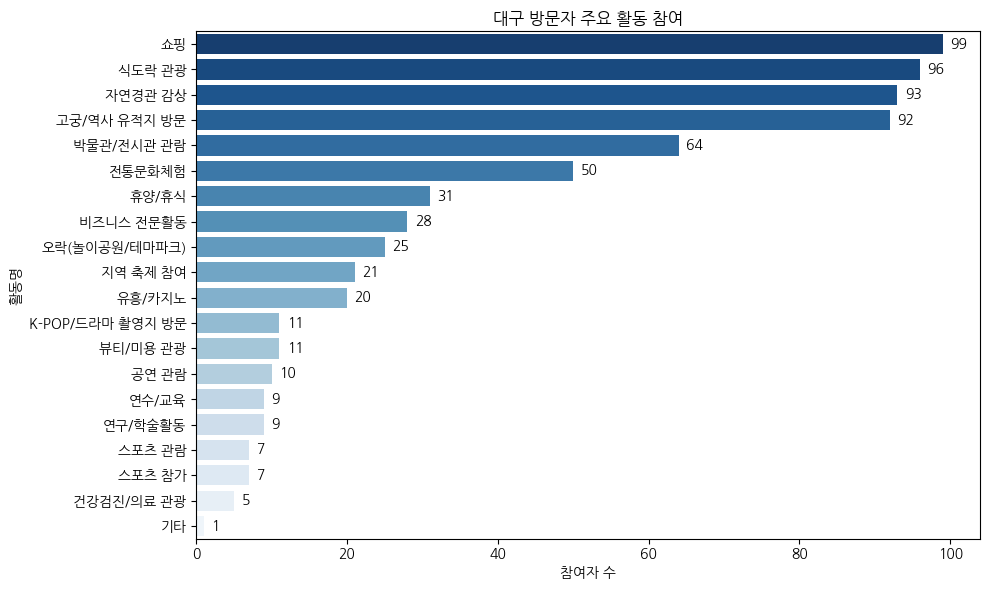

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=activity_named.values,
    y=activity_named.index,
    palette="Blues_r"
)

# 각 막대 끝에 수치 표시
for bar in ax.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(width + 1, y_pos, f'{int(width)}', va='center', fontsize=10)

plt.title("대구 방문자 주요 활동 참여")
plt.xlabel("참여자 수")
plt.ylabel("활동명")
plt.tight_layout()
plt.show()


/tmp/ipython-input-51-3070747794.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


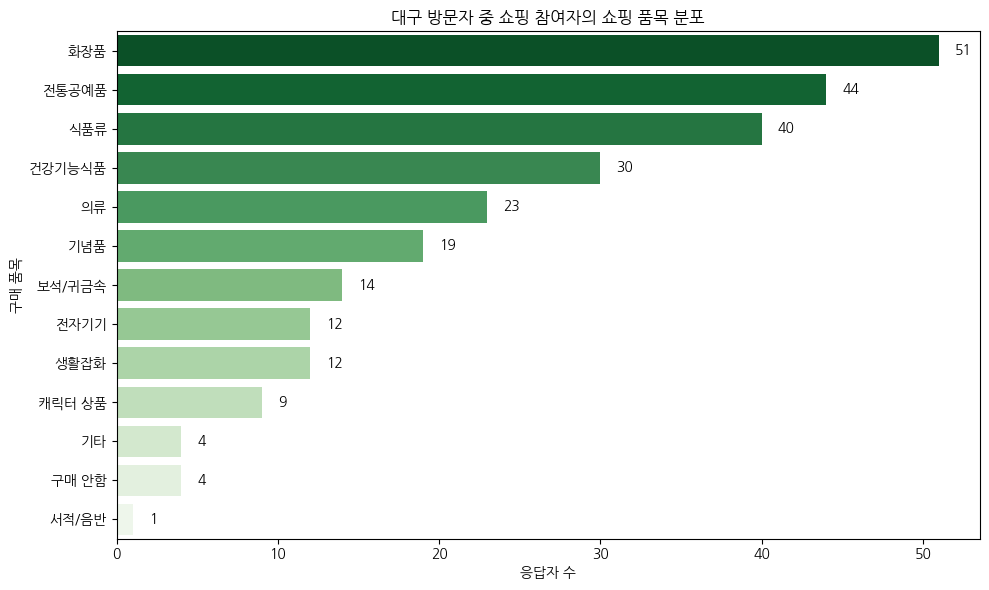

In [ ]:
# 1. 대구 방문자 중 쇼핑(Q8a02) 참여자 필터링
df_daegu_shopping = df_cluster1_2024[
    (df_cluster1_2024["Q9_2a11"] == "대구") &
    (df_cluster1_2024["Q8a02"].notna())
]

# 2. 쇼핑 품목 관련 변수명
shopping_item_cols = [f"Q10_2a{str(i).zfill(2)}" for i in range(1, 14)]

# 3. 항목별 응답자 수 집계
shopping_counts = df_daegu_shopping[shopping_item_cols].notna().sum().sort_values(ascending=False)

# 4. 코드북 기반 매핑
shopping_item_map = {
    "Q10_2a01": "식품류",
    "Q10_2a02": "전통공예품",
    "Q10_2a03": "화장품",
    "Q10_2a04": "의류",
    "Q10_2a05": "캐릭터 상품",
    "Q10_2a06": "기념품",
    "Q10_2a07": "생활잡화",
    "Q10_2a08": "전자기기",
    "Q10_2a09": "서적/음반",
    "Q10_2a10": "건강기능식품",
    "Q10_2a11": "보석/귀금속",
    "Q10_2a12": "기타",
    "Q10_2a13": "구매 안함"
}

# 5. 이름 붙이기
shopping_counts_named = shopping_counts.rename(index=shopping_item_map)

# 6. 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=shopping_counts_named.values,
    y=shopping_counts_named.index,
    palette="Greens_r"
)

# 막대 끝에 수치 표시
for bar in ax.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(width + 1, y_pos, f'{int(width)}', va='center', fontsize=10)

plt.title("대구 방문자 중 쇼핑 참여자의 쇼핑 품목 분포")
plt.xlabel("응답자 수")
plt.ylabel("구매 품목")
plt.tight_layout()
plt.show()


## **대구 방문자의 만족 활동 (누적)**

/tmp/ipython-input-45-3069384154.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


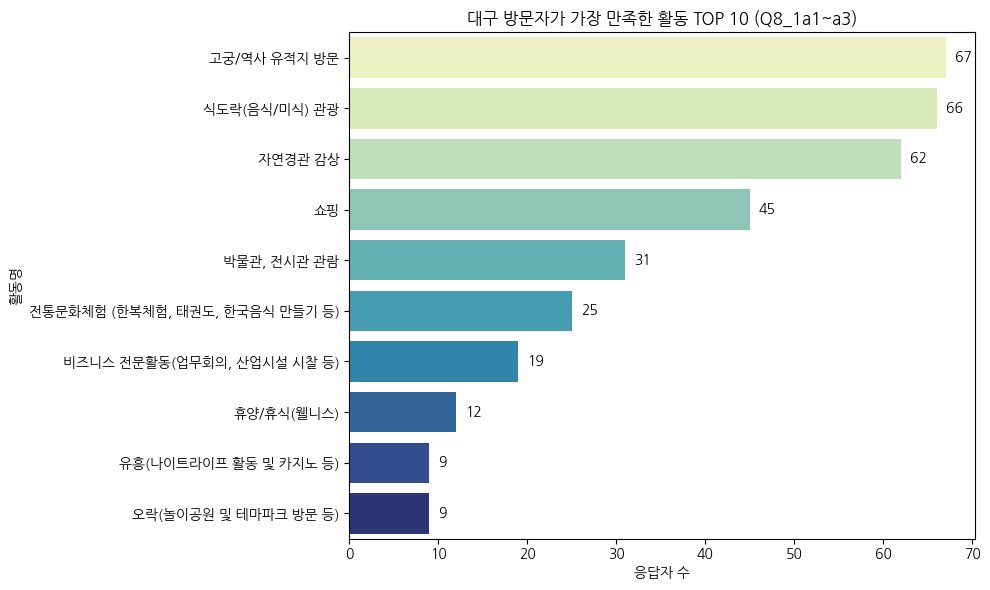

In [ ]:
# 1. 대구 방문자만 추출
dg = df_cluster1_2024[df_cluster1_2024["Q9_2a11"] == "대구"]

# 2. 만족한 활동 3개 항목 추출
satisfied_cols = ["Q8_1a1", "Q8_1a2", "Q8_1a3"]
dg_satis = dg[satisfied_cols]

# 3. 세 칼럼을 모두 하나로 합쳐서 Series로 만들기 (NaN 제외)
satis_combined = pd.concat([dg_satis[col] for col in satisfied_cols]).dropna()

# 4. 응답 항목별 빈도 집계
satis_counts = satis_combined.value_counts()

# 5. 시각화 (상위 10개 활동만 표시)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=satis_counts.values[:10],
    y=satis_counts.index[:10],
    palette="YlGnBu"
)

# 수치 표시
for bar in ax.patches:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    ax.text(width + 1, y_pos, f"{int(width)}", va='center', fontsize=10)

plt.title("대구 방문자가 가장 만족한 활동 TOP 10 (Q8_1a1~a3)")
plt.xlabel("응답자 수")
plt.ylabel("활동명")
plt.tight_layout()
plt.show()


## **대구 방문자의 활동 만족도**

/tmp/ipython-input-65-1378606164.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_satis = df_satis.applymap(satisfaction_map.get)


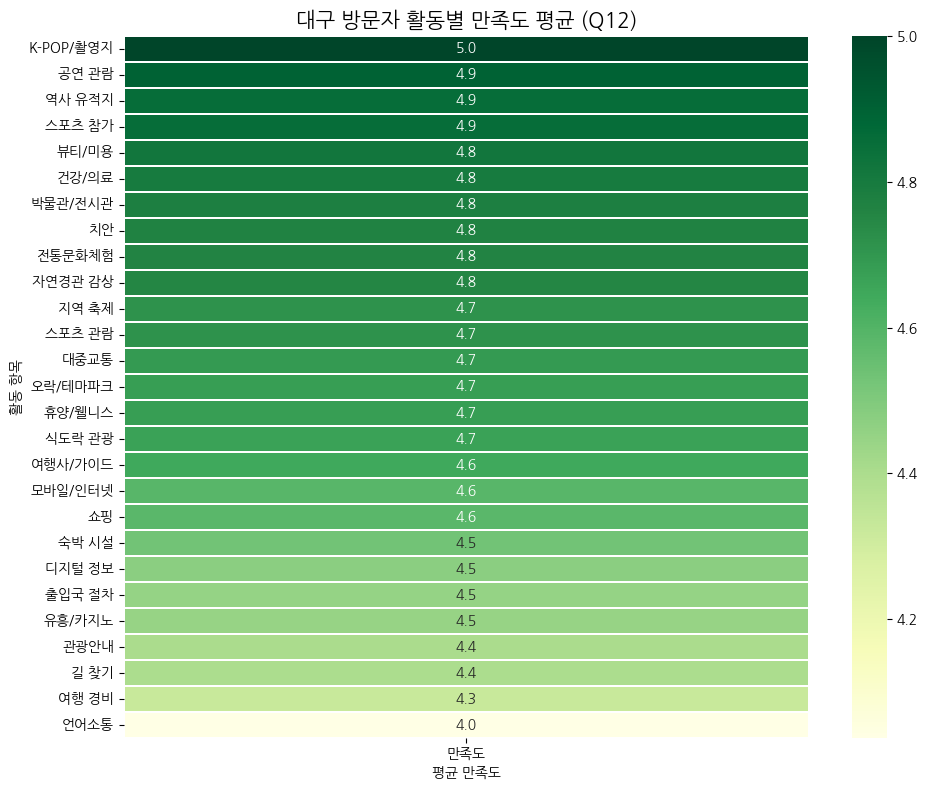

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 문자 → 숫자 매핑
satisfaction_map = {
    "⑤ 매우 만족": 5,
    "④ 만족": 4,
    "③ 보통": 3,
    "② 불만족": 2,
    "① 매우 불만족": 1
}

# 만족도 컬럼 및 라벨
satisfaction_cols = [f"Q12a{str(i).zfill(2)}" for i in range(1, 28)]

q12a_labels = {
    "Q12a01": "식도락 관광",
    "Q12a02": "쇼핑",
    "Q12a03": "자연경관 감상",
    "Q12a04": "휴양/웰니스",
    "Q12a05": "역사 유적지",
    "Q12a06": "전통문화체험",
    "Q12a07": "박물관/전시관",
    "Q12a08": "K-POP/촬영지",
    "Q12a09": "공연 관람",
    "Q12a10": "지역 축제",
    "Q12a11": "유흥/카지노",
    "Q12a12": "오락/테마파크",
    "Q12a13": "뷰티/미용",
    "Q12a14": "건강/의료",
    "Q12a15": "스포츠 관람",
    "Q12a16": "스포츠 참가",
    "Q12a17": "출입국 절차",
    "Q12a18": "언어소통",
    "Q12a19": "치안",
    "Q12a20": "여행 경비",
    "Q12a21": "숙박 시설",
    "Q12a22": "대중교통",
    "Q12a23": "길 찾기",
    "Q12a24": "관광안내",
    "Q12a25": "모바일/인터넷",
    "Q12a26": "디지털 정보",
    "Q12a27": "여행사/가이드"
}

# 누락 대응
for col in satisfaction_cols:
    if col not in q12a_labels:
        q12a_labels[col] = col

# 1. 대구 방문자 필터링
df_daegu = df_cluster1_2024[df_cluster1_2024["Q9_2a11"] == "대구"]

# 2. 만족도 숫자화
df_satis = df_daegu[satisfaction_cols].copy()
df_satis = df_satis.applymap(satisfaction_map.get)

# 3. 평균 계산
mean_satis = df_satis.mean().rename(index=q12a_labels).to_frame(name='만족도')

# 평균 만족도 높은 순으로 정렬
mean_satis_sorted = mean_satis.sort_values("만족도", ascending=False)

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(mean_satis_sorted, annot=True, fmt=".1f", cmap="YlGn", linewidths=0.3)

plt.title("대구 방문자 활동별 만족도 평균 (Q12)", fontsize=15)
plt.xlabel("평균 만족도")
plt.ylabel("활동 항목")
plt.tight_layout()
plt.show()


In [ ]:
# 평균 만족도 높은 순 정렬된 표 보기
display(mean_satis_sorted.style.background_gradient(cmap='YlGn').format("{:.2f}"))


,만족도
K-POP/촬영지,5.00
공연 관람,4.90
역사 유적지,4.86
스포츠 참가,4.86
뷰티/미용,4.82
건강/의료,4.80
박물관/전시관,4.78
치안,4.77
전통문화체험,4.76
자연경관 감상,4.75


/tmp/ipython-input-62-2847488588.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_satis_sorted['만족도'], y=mean_satis_sorted.index, palette="YlGn_r")


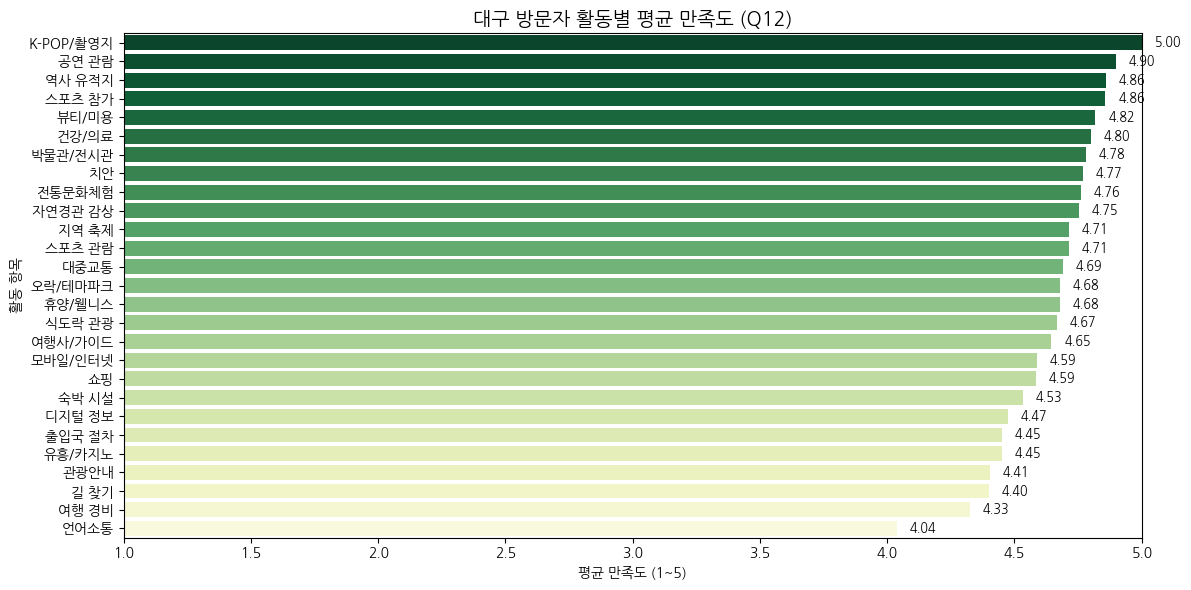

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 평균 만족도 높은 순으로 정렬
mean_satis_sorted = mean_satis.sort_values("만족도", ascending=False)

# 2. 막대그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_satis_sorted['만족도'], y=mean_satis_sorted.index, palette="YlGn_r")

# 3. 값 표시
for i, value in enumerate(mean_satis_sorted['만족도']):
    plt.text(value + 0.05, i, f"{value:.2f}", va='center', fontsize=9)

# 4. 그래프 스타일
plt.title("대구 방문자 활동별 평균 만족도 (Q12)", fontsize=14)
plt.xlabel("평균 만족도 (1~5)")
plt.ylabel("활동 항목")
plt.xlim(1, 5)  # 만족도 범위 고정 (옵션)
plt.tight_layout()
plt.show()


## 타지역 방문자의 활동 만족도 비교

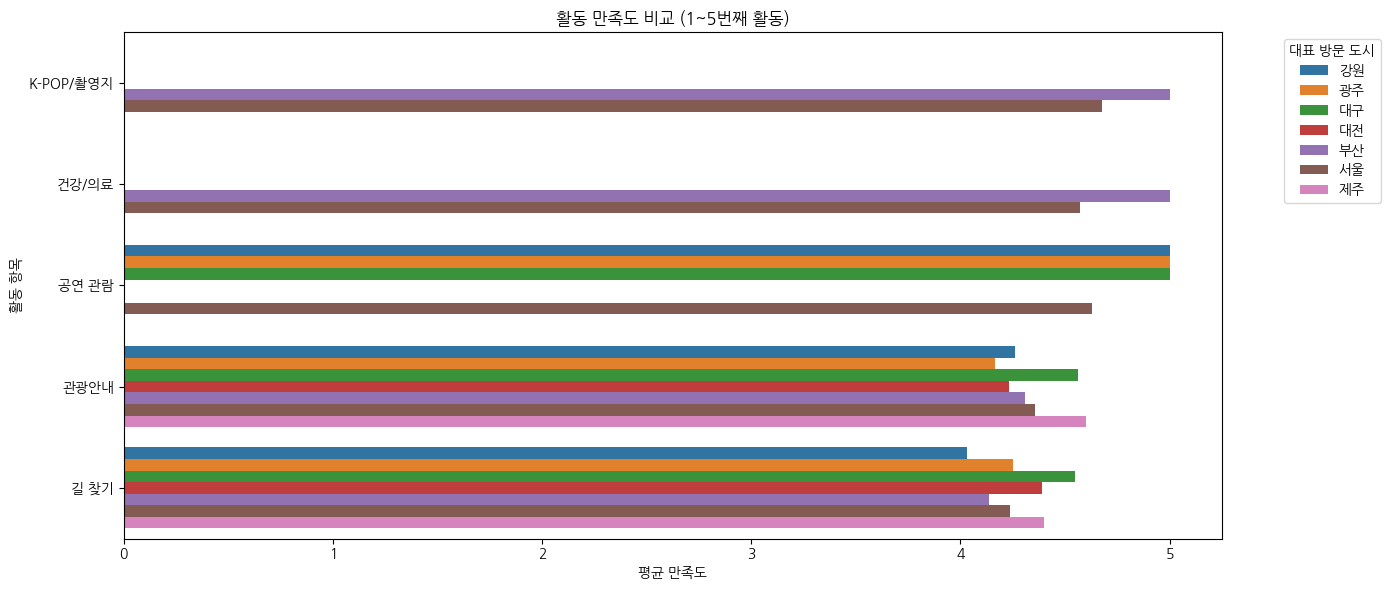

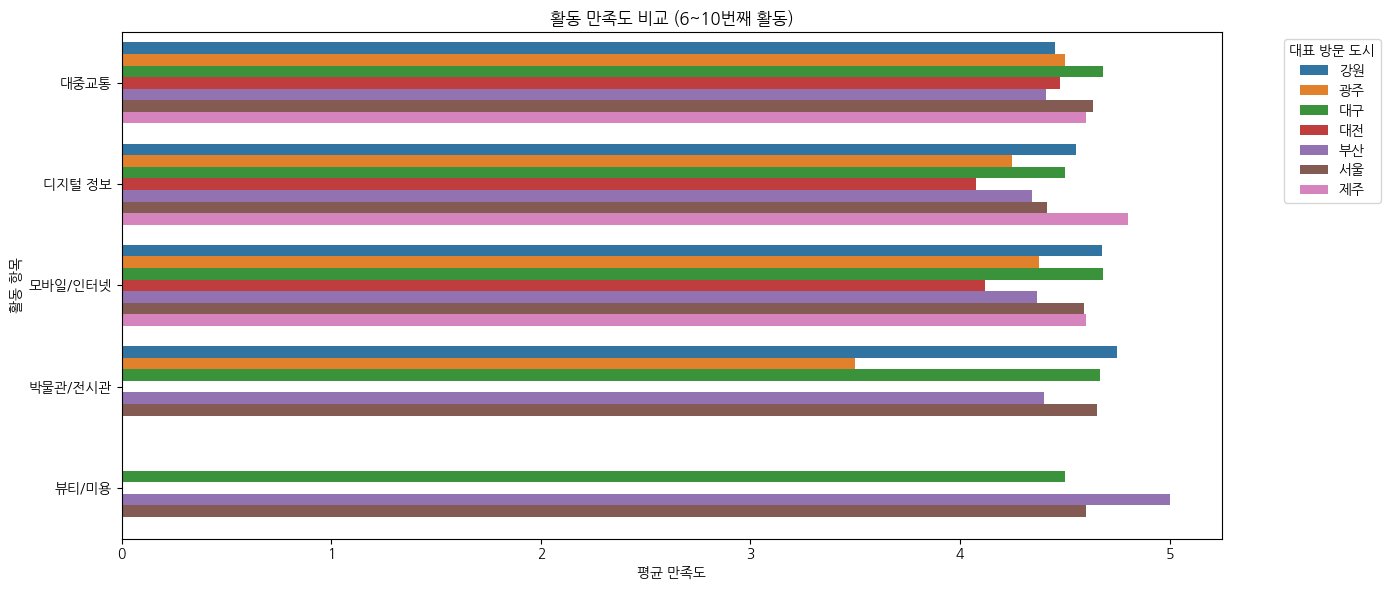

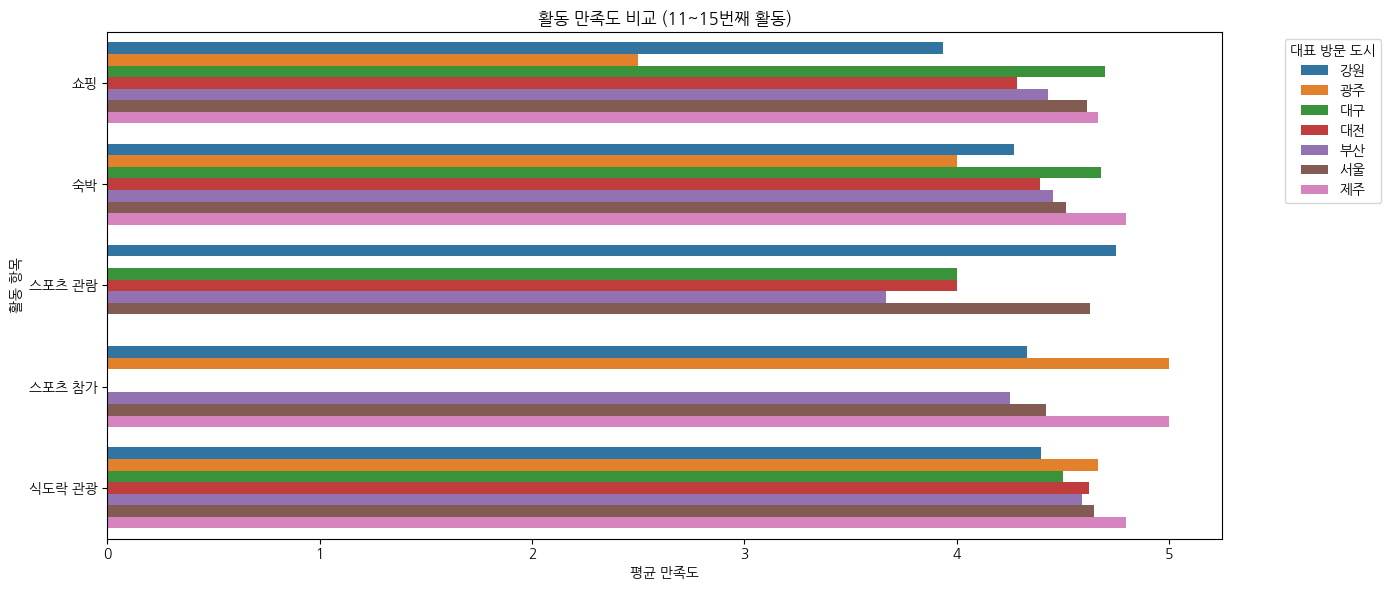

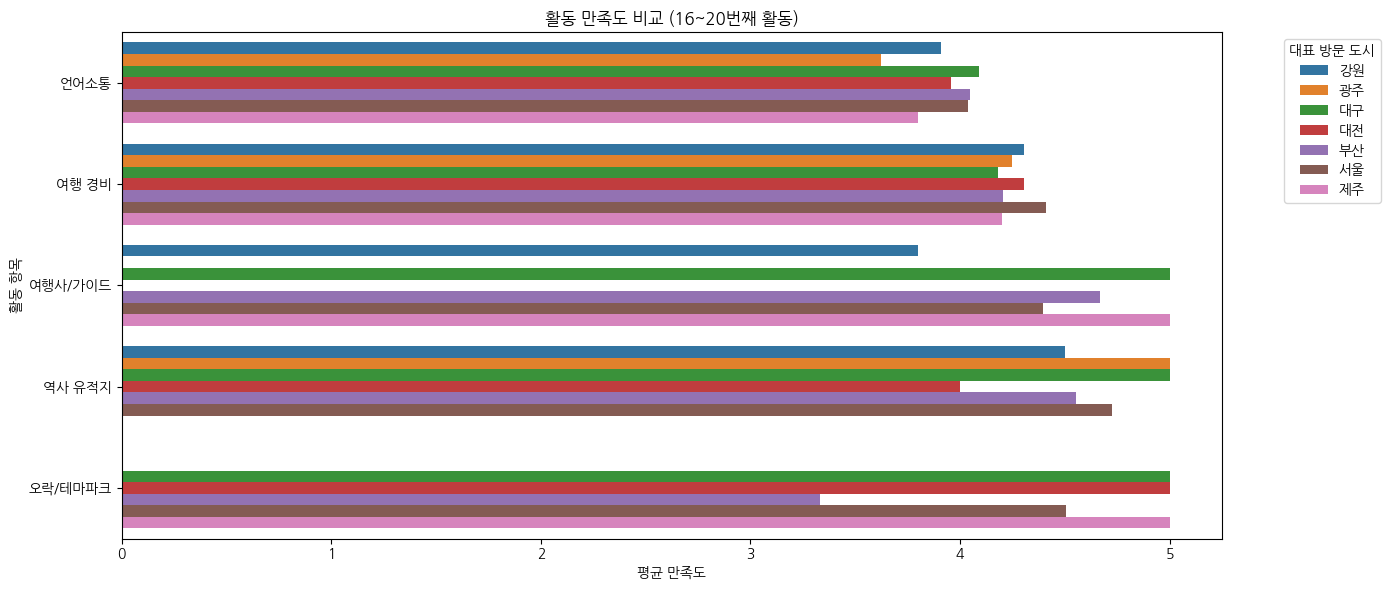

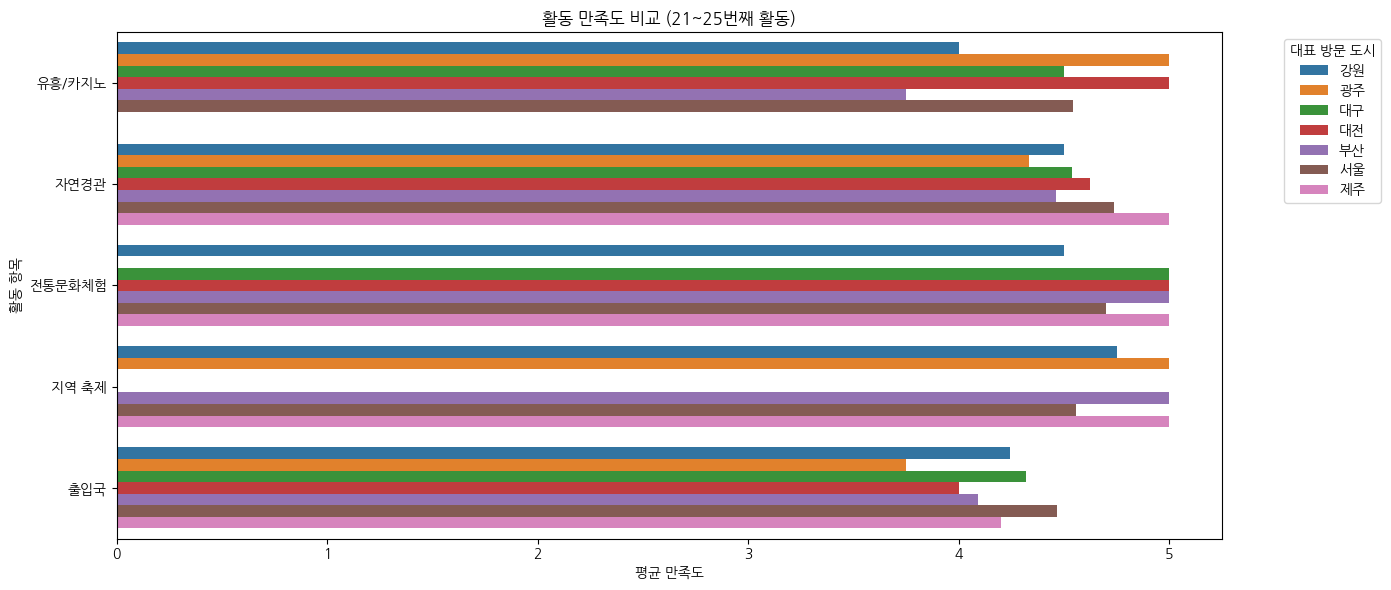

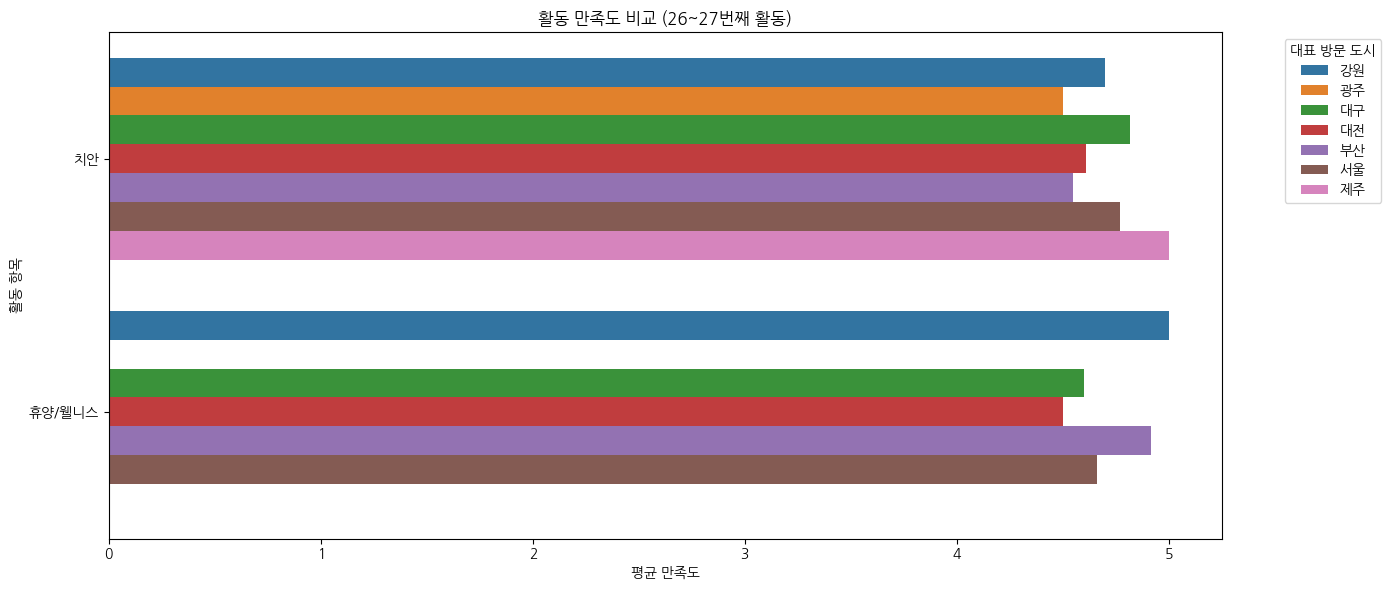

In [ ]:
# 활동 목록 정렬 (예: 알파벳순 → 필요시 변경 가능)
activity_list = sorted(filtered_df["활동"].dropna().unique())

# 활동을 5개씩 묶어 반복
step = 5
for i in range(0, len(activity_list), step):
    subset_activities = activity_list[i:i + step]

    # 필터링
    subset = grouped[grouped["활동"].isin(subset_activities)]

    # 시각화
    plt.figure(figsize=(14, 6))
    sns.barplot(data=subset, x="만족도", y="활동", hue="대표방문도시")
    plt.title(f"활동 만족도 비교 ({i+1}~{i+len(subset_activities)}번째 활동)")
    plt.xlabel("평균 만족도")
    plt.ylabel("활동 항목")
    plt.legend(title="대표 방문 도시", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# 피벗: 활동 × 도시 → 만족도 평균
pivot_table = grouped.pivot(index="대표방문도시", columns="활동", values="만족도")

# 도시별 Top-5 활동
top5_per_city = pivot_table.apply(lambda x: x.sort_values(ascending=False).head(5), axis=1)

# 보기 쉽게 정리
top5_summary = top5_per_city.stack().reset_index()
top5_summary.columns = ["대표방문도시", "활동", "만족도"]

# 표시
import pandas as pd
from IPython.display import display
display(top5_summary)


,대표방문도시,활동,만족도
0,강원,공연 관람,5.000000
1,강원,박물관/전시관,4.750000
2,강원,스포츠 관람,4.750000
3,강원,지역 축제,4.750000
4,강원,휴양/웰니스,5.000000
...,...,...,...
80,충북,관광안내,5.000000
81,충북,디지털 정보,5.000000
82,충북,모바일/인터넷,4.750000
83,충북,뷰티/미용,5.000000


## 대구 방문자의 활동별 만족도를 바탕으로 회귀분석 + 회귀 계수 파악



In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 1. 데이터 필터링: 대구 방문자
df = df_cluster1_2024[df_cluster1_2024["Q9_2a11"] == "대구"].copy()

# 2. 타깃 설정: 재방문 의향 (Q13 >= 4 → 1, 아니면 0)
df["target"] = (df["Q13"].map({"⑤ 매우 그렇다": 5, "④ 그렇다": 4, "③ 보통이다": 3, "② 그렇지 않다": 2, "① 전혀 그렇지 않다": 1}) >= 4).astype(int)

# 3. 피처 선택 (예시)
feature_cols = []
feature_cols += [col for col in df.columns if col.startswith("Q8a")]   # 활동 참여
feature_cols += [col for col in df.columns if col.startswith("Q12a")]  # 정보 획득 경로
feature_cols += ["D_NAT"]                                              # 국가

# 4. 결측치 제거
df_model = df[["target", "weight"] + feature_cols].dropna()

# 5. 범주형 변수 → 원-핫 인코딩
X = pd.get_dummies(df_model[feature_cols])
y = df_model["target"]
sample_weight = df_model["weight"]

# 6. 데이터 분리
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.3, random_state=42
)

# 7-1. L1 로지스틱 회귀
logreg = LogisticRegression(penalty="l1", solver="liblinear", max_iter=500)
logreg.fit(X_train, y_train, sample_weight=sw_train)
log_pred = logreg.predict(X_test)
print("📌 [로지스틱 회귀 보고서]")
print(classification_report(y_test, log_pred))

# 변수 중요도 (L1 계수)
coef_series = pd.Series(logreg.coef_[0], index=X.columns)
coef_nonzero = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)

# 7-2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train, sample_weight=sw_train)
rf_pred = rf.predict(X_test)
print("📌 [랜덤 포레스트 보고서]")
print(classification_report(y_test, rf_pred))

# 변수 중요도 시각화 (랜덤포레스트 기준)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_importances = importances.head(20)

plt.figure(figsize=(10, 6))
top_importances.plot(kind="barh")
plt.title("🎯 랜덤 포레스트 기준 상위 중요 변수")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# 1. 전체 대구 데이터
df = df_cluster1_2024[df_cluster1_2024["Q9_2a11"] == "대구"].copy()

# 2. 타깃 생성
q13_map = {
    "⑤ 매우 그렇다": 5, "④ 그렇다": 4, "③ 보통이다": 3, "② 그렇지 않다": 2, "① 전혀 그렇지 않다": 1
}
df["Q13_num"] = df["Q13"].map(q13_map)
df["target"] = (df["Q13_num"] >= 4).astype(int)

# 3. 피처 후보군 수집
feature_cols = []
feature_cols += [col for col in df.columns if col.startswith("Q8a")]   # 활동 참여
feature_cols += [col for col in df.columns if col.startswith("Q12a")]  # 정보경로
feature_cols += ["D_NAT"]                                              # 국가

# 4. 피처별 결측 비율 확인
missing_ratio = df[feature_cols].isna().mean()
valid_features = missing_ratio[missing_ratio < 0.5].index.tolist()  # 결측률 50% 미만만 사용

# 5. 모델링 데이터 구성
df_model = df[["target", "weight"] + valid_features].dropna()
print("사용 가능한 데이터 수:", len(df_model))

# 6. 원-핫 인코딩
X = pd.get_dummies(df_model[valid_features])
y = df_model["target"]
sample_weight = df_model["weight"]

# 7. 학습/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.3, random_state=42
)

# 이후는 기존 코드와 동일 (로지스틱 회귀, 랜덤포레스트 등)


사용 가능한 데이터 수: 46


[[1 3]
 [2 8]]
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.73      0.80      0.76        10

    accuracy                           0.64        14
   macro avg       0.53      0.53      0.52        14
weighted avg       0.61      0.64      0.63        14



/tmp/ipython-input-80-2456126737.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="coefficient", y="feature", palette="coolwarm")


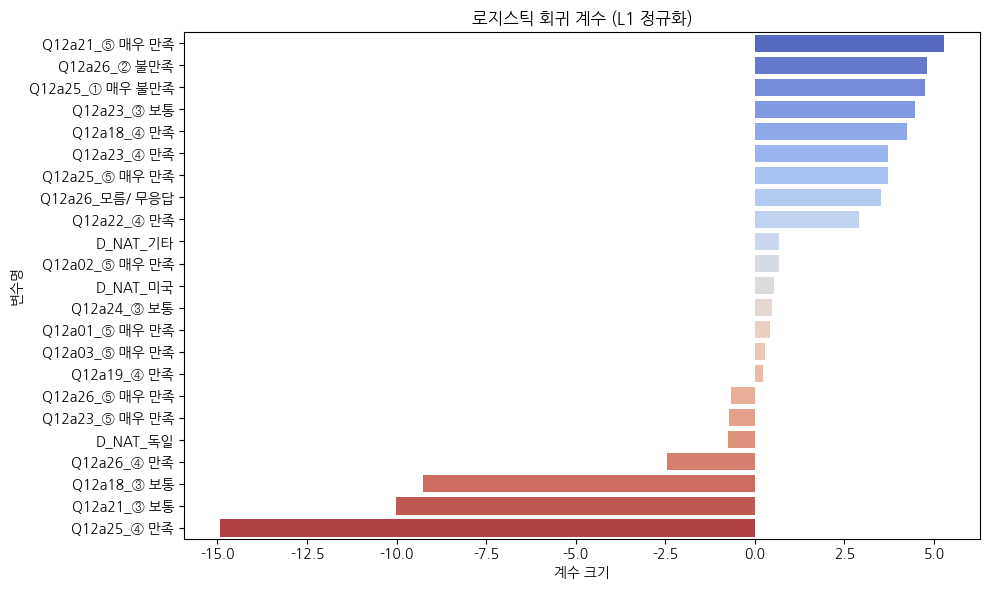

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 1. 로지스틱 회귀 (L1 정규화)
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
logreg.fit(X_train, y_train, sample_weight=sw_train)

# 2. 예측 및 평가
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 3. 변수 중요도 (L1 계수)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": logreg.coef_[0]
})
coef_df = coef_df[coef_df["coefficient"] != 0].sort_values(by="coefficient", ascending=False)

# 4. 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="coefficient", y="feature", palette="coolwarm")
plt.title("로지스틱 회귀 계수 (L1 정규화)")
plt.xlabel("계수 크기")
plt.ylabel("변수명")
plt.tight_layout()
plt.show()
